# Input Attribution with Captum on Encoders for Multiple Choice and Embedding Models

## Introduction and Conclusion

This notebook presents several potential applications for input attribution. The main motivation for exploring this was to examine physical intuitions and misconceptions in a model on the FCI in a somewhat quantitative way, as will be described in detail in the first section. 

Initial results with Captum gave promising results, and I overoptimistically attempted several applications. However, the results were inconsistent and sometimes nonsensical, warranting more in-depth testing. Indeed, the input attributions failed even very simple stability tests, such as adding a space to the question, exchanging synonyms or reordering words. This effectively renderes the method useless for actually answering any of the research questions posed in the notebook, and so, very disappointingly, none of them have been completed.

The first two applications are still highly interesting, and should be viewed as suggestions for future research. However, the simple attribution method I employ is too weak, so that a satisfactory solution to either application will likely require a more systematic/sophisticated approach. One could hope that consistency would be somewhat improved with a bigger, better model, but I am skeptical that this is enough. 

One should also keep the option in mind that there may be errors in the code (though there are no error messages), especially because the Captum-documentation is often vague when it comes to describing tensor shapes for the inputs and outputs for a function. There are Captum-demos online, [one of which](https://captum.ai/tutorials/Bert_SQUAD_Interpret) lies very close to what we do and provides inspiration for many methods (though not for multiple choice specifically, and this one attributes to isolated non-attention layers), indicating that the method is in principle applicable to transformers. Still, it should be mentioned that Captum is a general library for AI interpretability, and not specifically intended for transformers; I got increasingly worried throughout that the attention blocks in a transformer might move information between token positions in such a way that our attribution method picks up on a change at a different token than the one which really caused that change, since separator tokens which should be constant along the integration path sometimes got strongly attributed to.

Overall, I would advise against using Captum Integrated Gradients for Mechanistic Interpretability on Transformers, first and foremost because the reduction of a model to the mathematical function it represents disregards the model architechture, which runs counter to the paradigm of MI (the section on Integrated Gradients in the Report gives context on this point). This does not mean that input attribution is not interesting, nor that it cannot be used for probing LLM brains, but that it likely does not fall into the subfield of MI. Generally, more custom-made libraries like TransformerLens might show greater promise, see CE 3*.

Finally, in an unrelated appendix, we very briefly showcase Jina AI attention with BertViz, seemingly an excellent library for attention visualisation for non-causal models (encoders).

In [54]:
# Imports
import torch
from transformers import BertTokenizer, BertForMultipleChoice
from captum.attr import IntegratedGradients, LayerIntegratedGradients, LayerConductance
from captum.attr import visualization as viz
from dataclasses import dataclass

# Settings
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Config (only for debug here)
@dataclass
class Config:
    debug: bool = True
cfg = Config()

## Application I: Finding Physical Misunderstandings on the FCI of BERT-Style Models Fine-Tuned for Multiple Choice

We use Integrated Gradients from Captum to compute word attributions on the FCI for a BERT-model fine-tuned for answering mulitple choice questions. Specifically, we want to see whether the emphasised words indicate that the model exhibits the same common misconceptions as humans. In the example question below, even if the model gives a common wrong answer (eg. that the pushing car exerts a larger force, or that the heavier object exerts a larger force) we can perhaps use attribution to see precisely which words throw the model off, and then modify the prompt to determine by causal experiments what the model's misconception is. There is detailed qualitative research on student misconceptions on the FCI which could aid us greatly in finding likely misconceptions.

Alas, I cannot compute the gradients for large models with long inputs on my laptop, and our MpC-models are not trained for long physics questions, so the models used here cannot be used on the FCI. Instead, we demonstrate the methods on a basic test question.Ideally, the following code would be directly applicable to any appropriate model (potentially self fine-tuned for the purpose) with minimal adjustments, and we show as an example how to (very slighlty) modify it for a different architechture (RoBERTa).

But be warned again that even the test question results proves very unstable, and I have tried varying a bunch of parameters (the base model, the pretraining dataset, the question complexity, the question format, the number of choices, attributing wrt. logits and wrt. probabilities, and the baseline format) to mediate this without luck.

---

Example FCI-question: *A large truck breaks down out on the road and receives a push back into town by a small compact car. After the car reaches the constant cruising speed at which its driver wishes to push the truck:*

0) *The amount of force with which the car pushes on the truck is equal to that with which the truck pushes back on the car.*
1) *The amount of force with which the car pushes on the truck is smaller than that with which the truck pushes back on the car.*
2) *The amount of force with which the car pushes on the truck is greater than that with which the truck pushes back on the car.*
3) *The car's engine is running so the car pushes against the truck, but the truck's engine is not running so the truck cannot push back against the car. The truck is pushed forward simply because it is in the way of the car.*
4) *Neither the car nor the truck exert any force on the other. The truck is pushed forward simply because it is in the way of the car.*


In [55]:
# Test question (replace with some FCI-question)
question = "The capital of France is..." # we try to format the question like the model traning data
choices = ["Berlin", "Madrid", "Paris", ] # " Rome", " India"]
ground_truth_idx = 2

In [56]:
# Load model and tokenizer (replace with a model with some rudimentary physics understanding)
model_name = 'jonastokoliu/multi_choice_bert-base-uncased_swag_finetune' # Pretrained (bad) MpC model
model = BertForMultipleChoice.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()
# model # Uncomment to print architecture

First, we create a custom forward function, taking as arguments (all of shape [num_choices, seq_len])

> 1. the preembedded input tokens, 
> 2. the attention masks (since every choice may have a different length, we use padding tokens which should be masked) and
> 3. token type ids (which signify where the question ends and the choice begins),

and returning
 
> 1. the numbers we want to attribute with respect to (usually the logits). 

For multiple choice, we return a tensor [batch_size, num_choices], and we will specify the index to attribute (that will be the model's predicted index) in the final attribution call to reduce this tensor to a single scalar number. 

<details>
<summary>Discussion on logits versus softmaxed output for MpC (click to expand) </summary>

However, it might not be reasonable to use the logits for MpC: If using logits, only the choice index is relevant (there is no coupling between choices), and since every choice to a multiple choice question will often be designed to be somewhat feasible, this could make it so that every choice gets a positive overall attribution score. Said more plainly; it is possible for all logits to increase simultaneously, even though the model credence cannot increase for all choices simultaneously. However, softmax is highly non-linear, and the coupling may cause instability. Additionally, adding coupling means that we need to feed the model every choice, while logits would allow for faster computation since we would only need the choice we want to attribute with respect to. I have tested both, and alas, the results do seem to depend highly on the choice here.

For our imagined application (detecting misconceptions) we are mostly interested in how the question phrasing changes the credence for the given model choice, and so it should be fine to use logits. However, I have kept the code unoptimized such that one could just as well use a softmax/normalized input, if one would prefer. For real applications using logits, reduce the input, baseline, token types and attention masks by indexing with the choice_index before feeding into ig.attribute.

</details> 

Effectively, this function is just our way of telling Captum what number we should attribute with respect to, and we will later showcase how one could use this to attempt input attribution for an embedding model.

In [57]:
def forward_func_MpC(inputs_embeds, attention_mask, token_type_ids=None): 
    """Custom forward pass for Captum Integrated Gradients. 
    
    Captum expects a 2D tensor ([batch_size=num_choices, seq_len]),
    while mulitple choice/classification models expect [batch size, num_choices, seq_len],
    so we unsqueeze the first index to add batch_size=1. 
    We return the normalized logits for each choice.
    Some models (eg. RoBERTa) do not use token_type_ids, hence the optional parameter."""

    # Reshaping for multiple choice compatibility
    inputs_embeds = inputs_embeds.unsqueeze(0) # If attributing the embedding layer, this will be different, see below.
    attention_mask = attention_mask.unsqueeze(0)
    if token_type_ids is not None: token_type_ids = token_type_ids.unsqueeze(0)

    logits = model(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    ).logits

    if cfg.debug: print("Logit shape from forward pass:", logits.shape)
    return logits.softmax(dim=-1) # normalizing to differentiate choices (this is maybe not a good idea, it causes to much coupling / instability)

We now create a convenience function for tokenizing and preembedding the inputs (question + choices) and making the model prediction.

In [58]:
# Get input_ids, inputs_embeds, attention_masks, token_type_ids for Captum attribution methods 
# and make model prediciton to get probabilities and choice_idx

def get_encoding_and_predict(question, choices, tokenizer, embed_layer=model.bert.embeddings, type_tokens=True, print_output=True):
    """Tokenizes and preembeds the question and choices and makes prediction, returning input_ids, attention_masks, and token_type_ids, 
    logits and choice index. token_type_ids is None if token_types is False. The input ids are shaped as [num_choices, seq_len]."""
    
    # Tokenize for multiple choice and get input ids, attention masks, and token type ids
    encoding = tokenizer(
        [question] * len(choices),
        choices,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    input_ids = encoding["input_ids"]               # shape: [num_choices, seq_len]
    attention_masks = encoding["attention_mask"]    # -"-
    if type_tokens:
        token_type_ids = encoding["token_type_ids"] # -"-
    else:
        token_type_ids = None

    # Run input_ids through preembed layer
    inputs_embeds = embed_layer(input_ids, token_type_ids=token_type_ids) # position_ids are generated by default

    # Compute model prediction and get choice index
    probs = forward_func_MpC(inputs_embeds, attention_mask=attention_masks, token_type_ids=token_type_ids)
    choice_idx = torch.argmax(probs).item()

    if print_output:
        print('Question:', question)
        print('Predicted Answer:', f'{choice_idx})', choices[choice_idx])
    if cfg.debug: print('Probabilities:', probs) # To gauge model confidence

    # Get baseline with previous function
    return input_ids, inputs_embeds, attention_masks, token_type_ids, probs, choice_idx


# Quick computation
input_ids, inputs_embeds, attention_masks, token_type_ids, probs, choice_idx = get_encoding_and_predict(question, choices, tokenizer)

Logit shape from forward pass: torch.Size([1, 3])
Question: The capital of France is...
Predicted Answer: 2) Paris
Probabilities: tensor([[0.0098, 0.1466, 0.8436]], grad_fn=<SoftmaxBackward0>)


Integrated Gradients calculates the attribution by differentiation, varying the input between a baseline and the original input. The choice of baseline constitutes our second major choice, though this seemingly has a smaller effect on the results. If using logits, we would only care about the choice index, and the construction indicated in the inline comment below is most natural. However, when including coupling, one might either i) change every choice to the same baseline and move towards the true input, ii) change only the choice index and leave the unchosen choices the same in the baseline as in the true input or iii) replace the choice index with some other choice in the baseline. There are probably other options, but these are the ones I tested (briefly).

We chose option i), which seems the naive/most natual approach, but I find that the attribution score is confusing and unstable. The best way to address this might be to keep fixed words which may be irrelevant, so that we only replace the token for [France] with [PAD] and [paris] with [PAD]. This manual work would have the advantage of increased control, but also makes the results more dependent on subjective choices from the researcher (with this toy question it is pretty obvious which words are meaningful, but maybe not on the FCI. Also, empirically, small choices seem to have a potentially large effect on the results...).

Alterntaively, one could do the attribution wrt the question and wrt the choice separately, that is, keep the question xor choice fixed in the baseline, as is made possible by inline comments. Otherwise, the attribution will be influenced both by the changing question and the changing answer. I would assume this to be fine, since the subset of semantic space where the model has strong credences should intuitively be very small, but intuitions may be a dangerous thing. I did not test this, as instability seems to persist almost no matter what baseline one uses.

In [59]:
# Baseline inputs embeds for Integrated Gradients
def get_baseline(tokenizer, input_ids, choice_idx, embed_layer=model.bert.embeddings, ids=False):
    ref_token_id = tokenizer.pad_token_id   # padding
    sep_token_id = tokenizer.sep_token_id   # sepatator
    cls_token_id = tokenizer.cls_token_id   # start of sequence

    # Create baseline input: [CLS] [PAD] ... [PAD] [SEP] [PAD] ... [PAD] [SEP] [PAD] ... like choice_ids, expanded as input_ids
    ref_tokens = [cls_token_id]
    # question = True # switch to keep question the same in the baseline
    for token in input_ids[choice_idx, 1:]:
        if token == sep_token_id: # We keep only the separators, else we use padding
            ref_tokens += [sep_token_id] # Pythonic .append(sep_token_id)
    #        question = False # separator indicates end of question
    #    elif question: ref_tokens += [token]
        else:
            ref_tokens += [ref_token_id]
    
    ref_input_ids = torch.tensor(ref_tokens, dtype=torch.long).expand_as(input_ids)
    if ids: return ref_input_ids
    
    ref_token_type_ids = torch.zeros_like(ref_input_ids)
    return embed_layer(ref_input_ids, token_type_ids=ref_token_type_ids) # preembed for multi-layer attribution

# Quickly compute
ref_inputs_embeds = get_baseline(tokenizer, input_ids, choice_idx)

We now make a convenience function for getting the token attributions, summing over the internal model dimension to get an overal attribution for each position (token).

In [60]:
def get_token_attributions(forward_func, choice_idx, inputs_embeds, ref_inputs_embeds, attention_masks, token_type_ids=None, n_steps=50, attr_layer=None):

    if cfg.debug: print(inputs_embeds.shape)
    
    # LayerIntegratedGradients for attribution
    if attr_layer is None: ig = IntegratedGradients(forward_func)
    else: ig = LayerIntegratedGradients(forward_func, attr_layer) # Note that inputs_embeds may be input_ids if doing layer attribution

    # Compute attributions for chosen index 
    # (Captum wants [num_choices, seq_len] and gives attr shape [choices, seq_len, layer_output_dim])
    attributions, delta = ig.attribute(
        inputs=inputs_embeds,
        baselines=ref_inputs_embeds,
        additional_forward_args=(attention_masks, token_type_ids),
        target=choice_idx,              # Target the chosen answer, takes idx [0,target] of forward_func output
        n_steps=n_steps,                # Number of steps for approximation
        return_convergence_delta=True   # Error estimate
    )
    # Captum attributes every input wrt the target idx. We only care about the choice_idx attributions, 
    # but we have to pass in all the mulitple choice alternatives in order to get the correct softmax output.
    # This significantly increases compute time! So it is yet another reason to just use the logits, and then only pass in the
    # true index. But I am not sure if that really makes sense, since differentiation is important in MpC...
    if cfg.debug: print(attributions.shape)

    # Sum across layer_output_dim to get token-level importance
    choice_token_attributions = attributions[choice_idx].sum(dim=-1)  # shape: [num_choices, seq_len]
    choice_token_attributions = choice_token_attributions / torch.norm(choice_token_attributions)  # Normalize

    if cfg.debug: print('Attributions per token at choice_idx:', choice_token_attributions)
    
    return choice_token_attributions, delta

Here comes the main computation block, which can take several minutes with no GPU depending on the model, input length and number of steps. With our toy example, it should take seconds even on a laptop CPU.

In [61]:
# Main computation block, can take several minutes depending on the model, input length and number of steps.
# If cfg.debug is True, it will print intermediate results to indicate progress.
# choice_idx = 2 # Change this here if you want to attribute with choices different from the one the model chose

token_attributions, delta = get_token_attributions(
    forward_func_MpC, choice_idx, inputs_embeds, ref_inputs_embeds, attention_masks, token_type_ids, n_steps=50
)

# Convert input_ids to readable tokens for the choice_idx
tokens = tokenizer.convert_ids_to_tokens(input_ids[choice_idx])

torch.Size([3, 12, 768])
Logit shape from forward pass: torch.Size([1, 150])
Logit shape from forward pass: torch.Size([1, 3])
Logit shape from forward pass: torch.Size([1, 3])
torch.Size([3, 12, 768])
Attributions per token at choice_idx: tensor([ 0.0000,  0.1502,  0.0810,  0.1234,  0.3944,  0.2620, -0.4186, -0.5612,
        -0.1124,  0.0000,  0.4695, -0.0905], grad_fn=<DivBackward0>)


At last, we use Captum to make a neat visualisation of the attribution.

In [62]:
# Visualise
vis = viz.VisualizationDataRecord(
                        token_attributions,         # word attributions
                        torch.max(probs),           # prediction probability
                        torch.argmax(probs),        # predicted class
                        ground_truth_idx,           # ground truth class
                        choice_idx,                 # attributing to this class
                        token_attributions.sum(),   # summed attribution score
                        tokens,                     # tokens for the question and choice
                        delta,                      # convergence delta
)

visualisation = viz.visualize_text([vis]) # Save return object to avoid passing the vis object to the ipynb

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,0.30,[CLS] the capital of france is . . . [SEP] paris [SEP]


Indeed, the words "France" and "Paris" seems to be the main positive contributors, though the attribution score is very low (in fact, when changing the question format, it sometimes becomes negative, which is strange, as I have verified that the baseline is not preferred to the actual input. It could be because of some error in the code, or indicate that the choice of baseline is not good, or indicate an issue with the IG method). The model credence is also not amazing at about 85%, so a better model should be used.

#### Adapting for another model

This short section adds nothing new, but collects the above in a convenience function and shows how to apply it to a slightly bigger, and better, RoBERTa model. The only required modification is that RoBERTa does not use type_token_ids:

In [63]:
# Nothing new here, just importing the RoBERTa model. We use the question and choices from before, just reformatted to a RACE-like format
from transformers import RobertaTokenizer, RobertaForMultipleChoice

roberta_question = "What is the capitol of France?" # we try to format the question like the model traning data

# Load model and tokenizer
model_name = "LIAMF-USP/roberta-large-finetuned-race"
model = RobertaForMultipleChoice.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()
# model # Uncomment to print architecture

Let's also test logits rather than softmax, since it is a lot faster, and this model is bigger:

In [64]:
def forward_func_MpC_logit(inputs_embeds, attention_mask, token_type_ids=None): 
    """Custom forward pass for Captum Integrated Gradients. Here with logits, so only pass the relevant choice input (shape [1, seq_len]).
    Some models (eg. RoBERTa) do not use token_type_ids, hence the optional parameter."""

    # Reshaping for multiple choice compatibility
    inputs_embeds = inputs_embeds.unsqueeze(0) # If attributing the embedding layer, this will be different, see below.
    attention_mask = attention_mask.unsqueeze(0)
    if token_type_ids is not None: token_type_ids = token_type_ids.unsqueeze(0)

    logit = model(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    ).logits

    if cfg.debug: print("Logit shape from forward pass:", logit.shape)
    return logit # normalizing to differentiate choices (this is maybe not a good idea, it causes to much coupling / instability)

All-in-one convenience wrapper:

In [65]:
def do_everything(forward_func, tokenizer, embed_layer, question=question, choices=choices, ground_truth_idx=ground_truth_idx, type_tokens=False, n_steps=50, ids=False, attr_layer=None):
    """A quick function to do everything we have implemented so far: tokenize, make prediction, compute attributions and visualize."""
    # Tokenize for multiple choice and get input ids, attention masks, WITHOUT token type ids (if token_types=False), 
    # and make prediction to get logits and choice index
    input_ids, inputs_embeds, attention_masks, token_type_ids, probs, choice_idx = get_encoding_and_predict(question, choices, tokenizer, embed_layer, type_tokens=type_tokens, print_output=cfg.debug)
    ref_inputs_embeds = get_baseline(tokenizer, input_ids, choice_idx, embed_layer, ids=ids)
    
    if type_tokens: token_type_ids = token_type_ids[choice_idx].unsqueeze(0)
    if ids: inputs_embeds = input_ids # the ids-bool sends embeds to ids if True; this is not important

    # Compute attributition at choice idx
    token_attributions, delta = get_token_attributions(
        forward_func, 0, inputs_embeds[choice_idx].unsqueeze(0), ref_inputs_embeds[choice_idx].unsqueeze(0), attention_masks[choice_idx].unsqueeze(0), token_type_ids, n_steps=n_steps, attr_layer=attr_layer
    )

    # Visualize
    tokens = tokenizer.convert_ids_to_tokens(input_ids[choice_idx])

    vis = viz.VisualizationDataRecord(
                        token_attributions,         # word attributions
                        torch.max(probs),           # prediction probability
                        torch.argmax(probs),        # predicted class
                        ground_truth_idx,           # ground truth class
                        choice_idx,            # attributing to this class
                        token_attributions.sum(),   # summed attribution score
                        tokens,                     # tokens for the question and choice
                        delta,                      # convergence delta
    )

    viz.visualize_text([vis])

Main computation block, which could take several minutes on a laptop CPU.

In [66]:
# Compute attributions for RoBERTa
embed_layer = model.roberta.embeddings
do_everything(forward_func_MpC_logit, tokenizer, embed_layer, question=roberta_question) # note: the attribution goes negative around n=20, here it is unstable: bad result

Logit shape from forward pass: torch.Size([1, 3])
Question: What is the capitol of France?
Predicted Answer: 2) Paris
Probabilities: tensor([[8.4838e-03, 9.4364e-04, 9.9057e-01]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 14, 1024])
Logit shape from forward pass: torch.Size([1, 50])
Logit shape from forward pass: torch.Size([1, 1])
Logit shape from forward pass: torch.Size([1, 1])
torch.Size([1, 14, 1024])
Attributions per token at choice_idx: tensor([ 0.0000,  0.1721,  0.3265,  0.0897,  0.3923,  0.2591, -0.1325, -0.0565,
         0.4022, -0.3390, -0.3900,  0.0660,  0.4252,  0.0000],
       grad_fn=<DivBackward0>)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.99),2,1.22,#s What Ġis Ġthe Ġcap itol Ġof ĠFrance ? #/s #/s Paris #/s #pad


Notice that the model credence is way better (99%) than the previous model's. Alas, it is still not great on the FCI, and preliminary testing indicates that it does not really make sense to talk about misconceptions here since the credences are so low (that is, the answers are almost random; I am not convinced that this model has developed any internal understanding of physics). This is not surprising, since the FCI questions are very different from the training data, and since the model is so small as to run on a laptop CPU.

Also, this attribution really does not make much sense, or at the very least, is not at all illuminating (Why are France and Paris not relevant? Does the attention move information about France and Paris to the separators, so that this is what we read off?). It could be that the attribution score is simply not a good score for multiple choice, since it has nothing to do with the actual model prediction with respect to the other choices, but only with respect to the path from the baseline to the actual input.

Overall, the results are disapointing, and we should already have our doubts about the following applications. Alas, I worked on them in parallell, as the Captum demos plus initial results made me confident that things would work out better. We present the applications with a focus on the interesting ideas which lie behind them.

### Application II: Comparing the Embedding Spaces of Different Models

For this, we need attribution for embedding models. To determine which words in a text chunk are most important for the placement of that chunk in embedding space, we must fist choose a metric on the embedding space and some reference vector. **I think this method is potentially useful for comparing the embedding spaces of different models: In particular, would the same words in a sentence be the most important for the sentence placement for several models? If we fine-tune one model for increased resolution on physics related concepts, could we use attribution to see increased sensitivity to physics related words?**

Concretely, we do the following:

> Given a text chunk, we run it thorugh the model to get the corresponding embedding vector. Then, we want to see which words in the chunk we should tune to get the largest change in embedding position; that is, we attribute with respect to the cosine similarity between the true output and the perturbed output.

Ideally, one might want to use a separate vector as a reference, but there is no canonical choice. If the dataset gives a natural pairing, such as in a MpC/QA-dataset, one could experiment with using the question as the reference vector. 

The following code gives the general procedure, but I am not sure how to test whether it is a sensible/useful approach. This is a particular example of how embedding models may cause difficulty in interpretability, since the output is non-interpretable. There are also other potential issues: i) In high dimensional spaces, most randomly chosen vectors are essentially orthogonal, so unless the perturbations are very small, we might just get orthogonality for all our perturbations, giving basically no information at all. ii) In principle, the model may weight different directions in embedding space differently, so that a small change along an axis which is very densely populated with different semantic concepts could be more meaningful than a large movement in a sparse direction. The first seems to be disproven by my results, but I have not investigated the second, as I suspect it will be model and input specific; the application in bold above could shed light on this. Also, if one accepts the linearity hypothesis, one might be less worried about ii).

In [67]:
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer # note that the class structures of Autos are slightly different when accessing embedding layers etc.

# Load model and tokenizer
model_name = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1" # embedding model
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()
# model # Uncomment to print architecture

Since we use the transformers library (as opposed to sentence_transformers), we have to do the mean pooling taking us from last hidden state to embedding vector ourselves. We essentially borrow the code from sentence_transformers, though we also manually run the first preembed layer in order to get differentiable numbers for captum (instead of the discrete input_ids). 

(In the code, we will for clarity use variable name suffices '_embeds' to denote prembeddings and '_embeddings' to denote mean-pooled model outputs.)

In [68]:
# Mean Pooling - from sentence transformers, nothing new here;
# essentially averaging over all positions to get the actual singe embedding for the whole chunk
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Uses preembedded input for IG
def embed_tokens(inputs_embeds, attention_mask=None): # Uses global model
    model_output = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask) # attn mask only needed for padding tokens on acausal models, and we have a single batch
    # Perform pooling and normalize
    embedding = mean_pooling(model_output, attention_mask)
    return F.normalize(embedding, p=2, dim=1)

We now create the preembedded input, preembedded baseline for IG, and the reference embeddings which will be used in the custom forward function.

In [69]:
# Compute baseline embedding
text = ['This is a test sentence.']
target_idx = 0 # only one input
encoding = tokenizer(text, padding=True, truncation=True, return_tensors='pt') # Tokenize

embed_layer = model.embeddings # get embed layer

# Model input
input_ids = encoding['input_ids'] # Get input ids, shape: [batch_size, seq_len]
attention_masks = encoding['attention_mask'] # Get attention masks (for each batch, same shape as input_ids)
inputs_embeds = embed_layer(input_ids)

length = input_ids.shape[1] # Length of the input sequence, used for normalization
if cfg.debug: print(inputs_embeds.shape)

# Baseline embedding for IG
baseline_token_id = tokenizer.pad_token_id 
baseline_ids = torch.full_like(input_ids, baseline_token_id)
baseline_embeds = embed_layer(baseline_ids)

# Reference embedding for distance computation
reference_embeddings = embed_tokens(inputs_embeds, attention_masks) # shape: [batch_size, embedding_dim]

if cfg.debug: print(inputs_embeds.shape, attention_masks.shape, baseline_embeds.shape, reference_embeddings.shape, ) # Debug shapes

torch.Size([1, 8, 384])
torch.Size([1, 8, 384]) torch.Size([1, 8]) torch.Size([1, 8, 384]) torch.Size([1, 384])


Custom forward function as described earlier:

In [70]:
def forward_func_cos_sim(inputs_embeds, attention_mask=None, reference_embeddings=reference_embeddings):
    """Custom forward pass for Captum Integrated Gradients for cosine similarity to reference embeddings."""
    
    embeddings = embed_tokens(inputs_embeds, attention_mask)
    sim = F.cosine_similarity(reference_embeddings, embeddings, dim=1) # Compute cosine similarity to baseline embedding

    if cfg.debug: print("Similarity:", sim.shape, sim)
    return sim # tensor of shape [batch_size]

We then do the attribution:

In [71]:
# Compute model prediction
start_dist = forward_func_cos_sim(inputs_embeds, attention_masks, reference_embeddings)
print("Original similarity:", start_dist.item()) # Print original distance, should be 1 with our choice of reference embeddings

ig = IntegratedGradients(forward_func_cos_sim)

# Compute attributions for chosen index (Captum wants [choices, seq_len] and gives attr shape [choices, seq_len, embedding_dim])
attributions, delta = ig.attribute(
    inputs=inputs_embeds,
    baselines=baseline_embeds,
    additional_forward_args=(attention_masks, reference_embeddings, ), 
    n_steps=50,  # Number of steps for approximation
    return_convergence_delta=True
)

Similarity: torch.Size([1]) tensor([1.0000], grad_fn=<SumBackward1>)
Original similarity: 1.0000001192092896
Similarity: torch.Size([50]) tensor([0.0680, 0.0681, 0.0684, 0.0688, 0.0694, 0.0701, 0.0709, 0.0718, 0.0729,
        0.0740, 0.0752, 0.0764, 0.0778, 0.0794, 0.0814, 0.0839, 0.0873, 0.0922,
        0.1005, 0.1165, 0.1387, 0.1696, 0.2188, 0.2881, 0.3692, 0.4593, 0.5581,
        0.6665, 0.7760, 0.8620, 0.9150, 0.9454, 0.9638, 0.9756, 0.9834, 0.9887,
        0.9924, 0.9949, 0.9966, 0.9977, 0.9985, 0.9990, 0.9994, 0.9996, 0.9998,
        0.9999, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)
Similarity: torch.Size([1]) tensor([0.0679])
Similarity: torch.Size([1]) tensor([1.0000])


Note that the change in cosine similarity seems pretty smooth and is not dense around 0, indicating that 50 steps are more than enough even in high dimensional spaces. 

At last, we visualise the results.

In [72]:
# Get word tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[target_idx])

# Aggregate attribution scores across embedding dimension like before (Current shape of attributions: [1, seq_len, emb_dim])
token_attributions = attributions.sum(dim=-1).squeeze(0) * (length-3)/2 # shape: [seq_len], 
                    # normalizing by (number of word tokens)/2 to increase plot resolution

# Printing token + attribution
print("Token-wise attributions:")
for token, score in zip(tokens, token_attributions):
    print(f"{token:>12} : {score.item():.4f}")

# We also use the captum-visualisation since it is pretty, though most variables will be irrelevant
vis = viz.VisualizationDataRecord(
                        token_attributions,        # token-wise attributions
                        0, # prediction probability (not relevant for distance attribution)
                        0, # predicted class            -"-
                        0, # ground truth class         -"-
                        0, # attributing to this class  -"-
                        token_attributions.sum(),  # summed attribution score (NA)
                        tokens,                    # tokens for the question and choice
                        delta,                     # convergence delta
)

visualisation = viz.visualize_text([vis]) # get return object to avoid passing the vis object to the ipynb

Token-wise attributions:
       [CLS] : 0.0085
        this : 0.1965
          is : 0.2935
           a : 0.3674
        test : 0.6209
    sentence : 0.3872
           . : 0.2487
       [SEP] : 0.2089


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,2.33,[CLS] this is a test sentence . [SEP]


Note that the table scores are set to zero, as no label prediction is made here. Still, I suppose we see that the by far most important word is "test", which seems intuitively reasonable, though gives only a quick proof of concept. Additionally, it is consistent with expectation that all positions are green and give positive attribution, as any change will give a positive deviation from identity; only the relative values are relevant.

## Application III: Finding Where Facts are Stored in the Model

### Layer-wise attribution

**(This application is not promising, as I have realised that logit attribution is much superior to input attribution for this purpouse.)**

Often, we may want to use input attribution to get a rough idea of where a feature may be located in a model. For instance, the fact that Paris is the capitol of France may be stored in some MLP-layer of the model (3blue1brown, likely simplified). Once the layer is identified, the specific neurons may ideally be localized with intervention methods (see notebook 1). This section makes an attempt at implementing such a rough fact-layer search on an encoder for multiple choice, but the results are not great.

First of all, we have seen that there are issues with the attribution score on multiple choice questions. A better way to do this, then, might be to just take the norm of the embedding space contribution of each layer wrt to the question and use the maximal one as the most contributing layer. This is more in line with typical MI, and I belive it might be implemented in part 1.

Still, the following does demonstrate some Captum, though it is essentially only an application of the BERT-tutorial on a MpC model.

In [73]:
# Realoding toy BERT model for piecewise notebook runs - nothing new here
model_name = 'jonastokoliu/multi_choice_bert-base-uncased_swag_finetune' # Pretrained (bad) MpC model
model = BertForMultipleChoice.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()

When doing layer-wise attribution, we want to leave the option open to attribute with respect to the preembed layer, in which case we should feed the input_ids rather than the inputs_embeds to the forward function (otherwise, the preembed layer is skipped in the forward pass of the model). This is generally allowed for Layer integrated gradients, but not for Integrated gradients. Since it is also simpler, we will do this from now on:

In [74]:
def forward_func_MpC_ids(input_ids, attention_mask, token_type_ids=None): 
    """Custom forward pass for Captum Layer Integrated Gradients. Like before, but without preembedding."""
    # shape fixes as explained before since running multiple choices
    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)
    if token_type_ids is not None: token_type_ids = token_type_ids.unsqueeze(0)

    logits = model(
        input_ids=input_ids, # note: ids now (transformers-models take either)
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    ).logits

    if cfg.debug: print("Logits from forward pass:", logits.shape)
    return logits.softmax(dim=-1)

We can then attribute with respect to the preembedding layer, like in the BERT Captum-demo (we made Layer attribution an option in the functions from before, so this is just a quick application):

In [75]:
embed_layer = model.bert.embeddings
attr_layer = embed_layer # if attr wrt different layer, change here

do_everything(forward_func_MpC_ids, tokenizer, embed_layer, type_tokens=True, ids=True, attr_layer=attr_layer)

Logit shape from forward pass: torch.Size([1, 3])
Question: The capital of France is...
Predicted Answer: 2) Paris
Probabilities: tensor([[0.0098, 0.1466, 0.8436]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 12])
Logits from forward pass: torch.Size([1, 1])
Logits from forward pass: torch.Size([1, 1])
Logits from forward pass: torch.Size([1, 50])
Logits from forward pass: torch.Size([1, 1])
Logits from forward pass: torch.Size([1, 1])
torch.Size([1, 12, 768])
Attributions per token at choice_idx: tensor([ 0.0000, -0.1881,  0.0229,  0.2386,  0.6101,  0.0266, -0.5507, -0.3914,
        -0.2787,  0.0000, -0.0085,  0.0000])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.52,[CLS] the capital of france is . . . [SEP] paris [SEP]


Note the negative overall attribution score; naively, this should indicate that the initial embedding layer did not prefer this choice above the baseline, and that only later layers corrected for this (though previous results indicate that there might be issues with the attribution score, or at the very least with this interpretation of it). If facts are mostly contained in MLP-layers (ref. 3blue1brown), that makes perfect sense: The basic lookuptable of the preembed layer should not be able to answer MpC-questions. 

We could now loop over and attribute wrt each MLP-layer:

In [76]:
cfg.debug = False # avoiding clutter
for i in range(len(model.bert.encoder.layer)):
    print(i+1, "th layer")
    attr_layer = model.bert.encoder.layer[i].output # if the hidden mlp layer, use .intermediate. Can also add .dense to do pre-(layerNorm/activation)
    do_everything(forward_func_MpC_ids, tokenizer, embed_layer, type_tokens=True, n_steps=30, ids=True, attr_layer=attr_layer)
    # break # To avoid long runtime, comment if you want to run all this for some reason
cfg.debug = True

1 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.22,[CLS] the capital of france is . . . [SEP] paris [SEP]


2 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.39,[CLS] the capital of france is . . . [SEP] paris [SEP]


3 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.32,[CLS] the capital of france is . . . [SEP] paris [SEP]


4 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.40,[CLS] the capital of france is . . . [SEP] paris [SEP]


5 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.40,[CLS] the capital of france is . . . [SEP] paris [SEP]


6 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.63,[CLS] the capital of france is . . . [SEP] paris [SEP]


7 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.50,[CLS] the capital of france is . . . [SEP] paris [SEP]


8 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.54,[CLS] the capital of france is . . . [SEP] paris [SEP]


9 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.97,[CLS] the capital of france is . . . [SEP] paris [SEP]


10 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-1.11,[CLS] the capital of france is . . . [SEP] paris [SEP]


11 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-0.91,[CLS] the capital of france is . . . [SEP] paris [SEP]


12 th layer


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,2 (0.84),2,-1.00,[CLS] the capital of france is . . . [SEP] paris [SEP]


The highest attribution score is for layer 10 (on earlier runs, it was positive, but now it is negative. Still, it is the largest in absolute value...), so this might be the best candidate for a "fact-layer". However, there are multiple serious issues: i) there is likely an issue with the attribution score; previous examples show negative scores for the preferred choice, and it is highly unstable when adding softmax instead of using the logits, like we do here. ii) the attribution scores are spread out over multiple layers, iii) the hypothesis that a "Paris is the capitol of France"-MLP-layer exists is not very well founded rendering this project potentially hopeless. The method should preferably be tested on a model where features have already been identified, to see if we can re-identify them with attribution+ablation, but we have no such model available in a reasonable size. Also, the last layer attribution is always non-sensical, and I am not sure why - this could maybe also hint at some issue with the full-model attribution we did earlier.

The cleaner way to get a layer overview is with Captum's Layer Conductance; this is either repetition of things we have done before, or follows the Captum BERT-demo, so the reader may skip to the conclusion.

In [77]:
from captum.attr import LayerConductance

# For plotting heatmaps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Returning to smaller BERT-model
model_name = 'jonastokoliu/multi_choice_bert-base-uncased_swag_finetune' # Pretrained (bad) MpC model
model = BertForMultipleChoice.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
embed_layer = model.bert.embeddings # get embed layer
# Set to evaluation mode
model.to(device)
model.eval()
model.zero_grad()

Some setup, like before:

In [78]:
# Setup
input_ids, inputs_embeds, attention_masks, token_type_ids, probs, choice_idx = get_encoding_and_predict(question, choices, tokenizer, embed_layer)
ref_inputs_embeds = get_baseline(tokenizer, input_ids, choice_idx, embed_layer)

ref_token_type_ids = torch.zeros_like(token_type_ids)  # Reference token type ids, all zeros for BERT
position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=device)  # Position ids for the input sequence
ref_position_ids = torch.zeros_like(position_ids)  # Reference position ids, all zeros for BERT

if cfg.debug: print(inputs_embeds.shape, ref_inputs_embeds.shape)

Logit shape from forward pass: torch.Size([1, 3])
Question: The capital of France is...
Predicted Answer: 2) Paris
Probabilities: tensor([[0.0098, 0.1466, 0.8436]], grad_fn=<SoftmaxBackward0>)
torch.Size([3, 12, 768]) torch.Size([3, 12, 768])


We then follow the demo to compute the LayerConductance:

In [79]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

layer_attrs = [] # Empty list to store attributions for each layer

for i in range(model.config.num_hidden_layers): # attrubuting tokenwise for each layer
    lc = LayerConductance(forward_func_MpC, model.bert.encoder.layer[i])
    layer_attributions = lc.attribute(inputs=inputs_embeds, baselines=ref_inputs_embeds, additional_forward_args=(attention_masks,), \
                                      target=choice_idx, n_steps=50, ) # may reduce steps to speed up, sacrificing acc
    layer_attrs.append(summarize_attributions(layer_attributions).cpu().detach().tolist())
    print(f"Layer {i+1}:", np.sum(layer_attrs[i][choice_idx]))

Logit shape from forward pass: torch.Size([1, 153])
Layer 1: 0.24013189412653446
Logit shape from forward pass: torch.Size([1, 153])
Layer 2: 0.29861432150937617
Logit shape from forward pass: torch.Size([1, 153])
Layer 3: 0.2996048768982291
Logit shape from forward pass: torch.Size([1, 153])
Layer 4: 0.22785718506202102
Logit shape from forward pass: torch.Size([1, 153])
Layer 5: 0.2197629723814316
Logit shape from forward pass: torch.Size([1, 153])
Layer 6: 0.48987919246428646
Logit shape from forward pass: torch.Size([1, 153])
Layer 7: 0.320753398060333
Logit shape from forward pass: torch.Size([1, 153])
Layer 8: 0.44283709302544594
Logit shape from forward pass: torch.Size([1, 153])
Layer 9: 0.59391481988132
Logit shape from forward pass: torch.Size([1, 153])
Layer 10: 0.8353027128614485
Logit shape from forward pass: torch.Size([1, 153])
Layer 11: 1.4307750158477575
Logit shape from forward pass: torch.Size([1, 153])
Layer 12: 0.7601543664932251


Here, layer 11 has the overall largest score - again, inconsistent with the results from the loop. Finally, we plot the results as a seaborn heatmap:

(12, 3, 12)


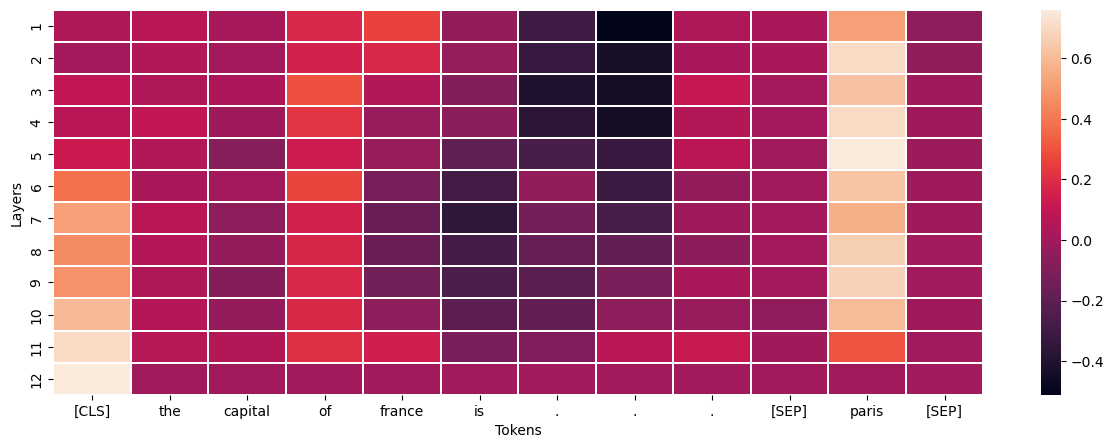

In [80]:
if cfg.debug: print(np.array(layer_attrs).shape)

# Plotting
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=tokenizer.convert_ids_to_tokens(input_ids[choice_idx])
yticklabels=list(range(1, model.config.num_hidden_layers+1))
ax = sns.heatmap(np.array(layer_attrs)[:,choice_idx,:], xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

We make no effort to interpret this closely, in light of instabilities, but the reader may compare with the layer-wise results; note especially as the 12th layer result of full weight on the CLS-token is reproduced, though the attribution weightings seem inverted (everywhere, which in this case makes them correct. This indicates a sign error in my Integrated Gradients application, though the results are not consistent: Sometimes the LayerConductance is negative while IG is positive). It is also clear that Paris is the standout token; this is nice to see.

It is also possible to look closely at specific tokens and how they are processed by each layer, see the very end of the [first Captum BERT demo](https://captum.ai/tutorials/Bert_SQUAD_Interpret) (This should be pretty much similar for our case when treating only the choice idx and using only one attribution rather than start and end).

## Appendix: Attention Visualisation with BertViz

For short inputs, we can visualise the full encoder attention. We do this here for a small and a large Jina AI-model. This part is a direct application of the CircutisVis documentation - it is not a big library, and it does only what it aims to do, seemingly very well.

Interactive visualisation of Jina AI attention, first in model view. Click the head you want to inspect in detail, and hover over individual tokens to see its weighted connections.

In [81]:
from transformers import AutoTokenizer, AutoModel, utils # torch >= 2.6
from bertviz import model_view, head_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = "jinaai/jina-embeddings-v2-base-en"  # jina
input_text = "Paris is the capitol of France"  # Attn visualisation is best for short prompts, obviously
model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

The small model gives clearer plots:

In [82]:
model_name = "jinaai/jina-embeddings-v2-small-en" 

model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

We can also visualise the heads separately (choose layer, color specifies head, press color to hide, hover over word to see attn):

In [83]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

---
<p align="center">
    End of document
</p>

---